---
# 准备

In [66]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
#@title Record Each Cell's Execution Time
#!pip install ipython-autotime

#%load_ext autotime

In [ ]:
#pip install --upgrade tensorflow

---
# NLG


In this tutorial, we will focus on how to **sample (select) the next token in Text Generation**.

**First**, we will introduce the text generation process. 

**Then**, we will briefly present the most common methods of sampling.

**Afterward**, we will implement three sampling methods: Greedy Sampling, Temperature Sampling, and Top-k sampling. We will discuss the advantages and disadvantages of these methods as well.

Thus, **in the end**, we will understand the sampling in Text Generation and prepare implementation of three popular sampling methods to use in upcoming parts for word-level text generation.



# 什么是 NLG？
A **Language Model (LM)** can be trained to generate text **word-by-word** or **character-by-character**. 

The input and output sequences given to the **LM** are made of tokens that are either a **word** or a **character**. 

In training, we supply a sequence of tokens as input (X) and a target token (next token to complete the input) as output (y)

After training, the Language Model learns to generate **a conditional probability distribution** over the **vocabulary** of tokens according to the **given  input sequence**.

Below, you see a **word-level** LM predicts  **a conditional probability distribution** over the word dictionary for the given word sequences "*I want to cook*"


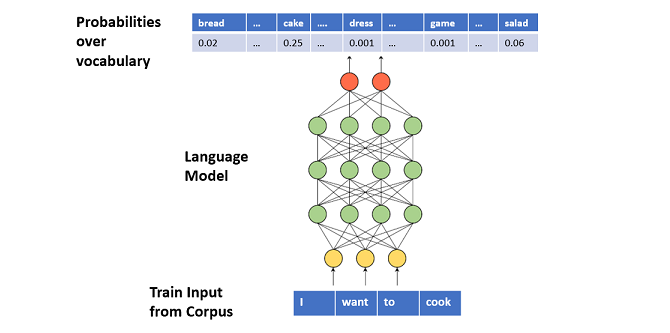

To generate text, we can iterate over the below steps: 
* **Step 1:** we provide **a sequence of words** to the Language Model as input
* **Step 2:** the Language Model outputs **a conditional probability distribution** over the **vocabulary**
* **Step 3:** we **sample** a word from the distribution
* **Step 4:** we **concatenate** the newly sampled word to the ***generated text***
* **Step 5:** **a new input sequence** is genereted by appending the newly sampled word


For more details, please check [Part A,  B, and C.](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)

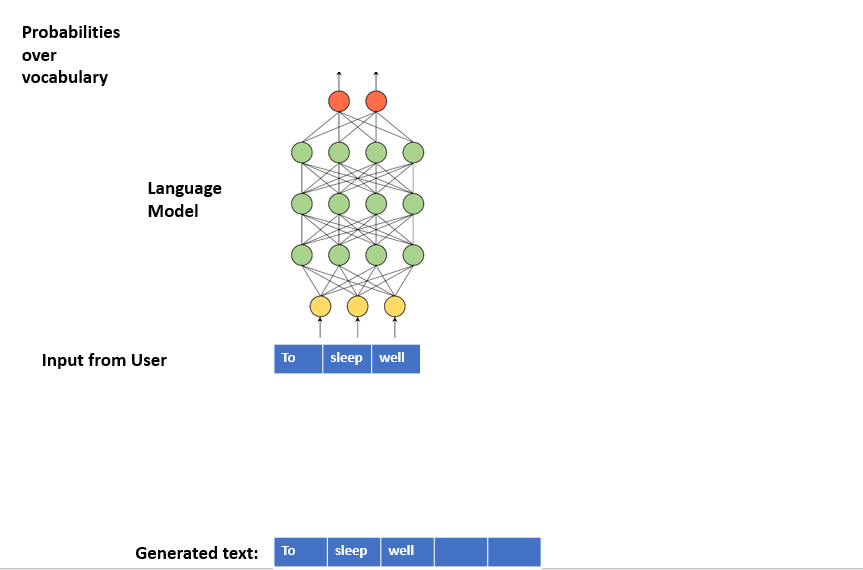

# NLG 解码策略
In Text Generation, **sampling** means randomly **picking** the next token according to the generated **conditional probability distribution**.

That is, after generating the conditional  probability distribution over the set of tokens (*vocabulary*) for the given input sequence, we need to  carefully decide how to **select the next token** (***sample***) from this distribution. 



There are **several methods for sampling** in text generation (see [here](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277) and [here](https://huggingface.co/blog/how-to-generate)):


* **Greedy Search (Maximization)** 
* **Beam Search**

* **Temperature Sampling**

* **Top-K Sampling**
* **Top-P Sampling (Nucleus sampling)**



In this tutorial, we will code Greedy Search, Temperature Sampling, and Top-K Sampling. 

In the end of the tutorial, I will introduce the Top-P Sampling and Beam Search briefly.


---
## 1. 训练一个语言模型


In this tutorial, since we are **more interested** in **sampling** methods and their implementations, we will **simulate** the conditional probability distribution over the token vocabulary by ***assuming*** that:


* We opt to generate text **character-by-character**. 

* We have a **vocabulary** of characters from **'a'** to **'z'**.

* We have already trained the **Language Model** with a corpus.
* Thus, the Language Model is ready to generate a **conditional probability distribution** over the  **token vocabulary** for a given input sequence.

* Now, we want to **sample** (select) the **next token** from the **conditional probability distribution**.

Let's prepare the simulated LM.


### 定义词典



In [67]:
dictionary =[]
for c in range(ord('a'), ord('z')+1):
    dictionary.append(chr(c))
dictionary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## 模拟一个已经被训练好的 LM

In [68]:
class language_model:
    def __init__(self, dictionary):
        self.dictionary = dictionary
    def predict(self):
        output= np.random.rand(len(dictionary))
        output=output/output.sum()
        return  output

model=language_model(dictionary)


## 模型生成的条件概率分布

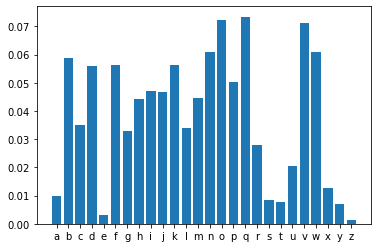

In [69]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

In [70]:
predictions.sum()

0.9999999999999999

Now, we can code several sampling methods and observe their behaviors.

---
## 2. Greedy Search 解码

**Greedy search** method simply ***selects*** the token with the **highest probability** as its next token (*word or char*). 

However, if we always sample the  most likely word, the standard language model training objective causes us to **get stuck in loops** like 

“*I don’t know. I don’t know. I don’t know. I don’t know.*”

In [71]:
def greedy_search(conditional_probability):
    return (np.argmax(conditional_probability))

In [72]:
next_token = greedy_search(predictions)
print("Sampled token: ",dictionary[next_token])

Sampled token:  q


## 3. Beam Search 解码

Another popular heuristic is the beam search that expands upon the greedy search and returns a list of most likely output sequences.

Instead of greedily choosing the most likely next step as the sequence is constructed, the beam search expands all possible next steps and keeps the k most likely, where k is a user-specified parameter and controls the number of beams or parallel searches through the sequence of probabilities.

We do not need to start with random states; instead, we start with the k most likely words as the first step in the sequence.

Common beam width values are 1 for a greedy search and values of 5 or 10 for common benchmark problems in machine translation. Larger beam widths result in better performance of a model as the multiple candidate sequences increase the likelihood of better matching a target sequence. This increased performance results in a decrease in decoding speed.

The search process can halt for each candidate separately either by reaching a maximum length, by reaching an end-of-sequence token, or by reaching a threshold likelihood.

Let’s make this concrete with an example.

We can define a function to perform the beam search for a given sequence of probabilities and beam width parameter k. At each step, each candidate sequence is expanded with all possible next steps. Each candidate step is scored by multiplying the probabilities together. The k sequences with the most likely probabilities are selected and all other candidates are pruned. The process then repeats until the end of the sequence.

Probabilities are small numbers and multiplying small numbers together creates very small numbers. To avoid underflowing the floating point numbers, the natural logarithm of the probabilities are added together, which keeps the numbers larger and manageable. Further, it is also common to perform the search by minimizing the score. This final tweak means that we can sort all candidate sequences in ascending order by their score and select the first k as the most likely candidate sequences.

The beam_search_decoder() function below implements the beam search decoder.

In [73]:
from math import log
from numpy import array
from numpy import argmax

def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# 迭代序列中的每一步
	for row in data:
		all_candidates = list()
		# 计算每种 hypotheses 的分值，并存储到 all_candidates
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# 对所有的候选序列，通过 score 排序
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# 选择 K 个分 score 最高的
		sequences = ordered[:k]
	return sequences

In [75]:
n = 10

data = []
for i in range(10):
    prediction = model.predict()
    data.append(prediction)
    
print(data)
data = array(data)
result = beam_search_decoder(data, 5)

for seq in result:
	print(seq)

[array([0.01080067, 0.01934691, 0.02751911, 0.03062609, 0.06508798,
       0.06849737, 0.0251669 , 0.0027683 , 0.05132621, 0.05912518,
       0.06842967, 0.03393318, 0.02126894, 0.02490831, 0.03710399,
       0.0314334 , 0.05979832, 0.03316234, 0.010927  , 0.0250518 ,
       0.03661362, 0.03851655, 0.04355691, 0.05227443, 0.05577468,
       0.06698217]), array([0.03043564, 0.046421  , 0.0311736 , 0.05103516, 0.06390527,
       0.01229862, 0.05086616, 0.02208612, 0.00770412, 0.00901657,
       0.03126087, 0.01109035, 0.06431288, 0.0475122 , 0.05399969,
       0.03463031, 0.0613755 , 0.03052601, 0.05568381, 0.04639417,
       0.00842138, 0.06409181, 0.06179457, 0.03066861, 0.04230536,
       0.0309902 ]), array([0.03066534, 0.08383182, 0.0687968 , 0.03066694, 0.02656097,
       0.06566867, 0.01047018, 0.05721253, 0.04683769, 0.04220485,
       0.02771271, 0.02958055, 0.0509471 , 0.06144479, 0.03305831,
       0.02250537, 0.07502489, 0.01177532, 0.04138088, 0.03684799,
       0.00599761, 

---
## 4. TEMPERATURE 采样

 

Temperature sampling is inspired by statistical thermodynamics, where ***high temperature*** means low energy states are more likely encountered. 

In probability models, **logits** play the role of energy and we can implement temperature sampling by **dividing logits by the temperature** before feeding them into ***softmax*** and obtaining our sampling probabilities.

  Below is an implementation for Temperature Sampling [taken from here](https://keras.io/examples/generative/lstm_character_level_text_generation/)




## 4.1 绘制模型生成的条件概率分布



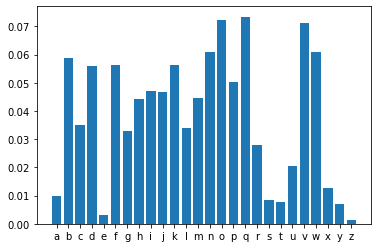

In [76]:
plt.bar(dictionary,predictions)
plt.show()

## 4.2 使用 “temperature” Reweighting 分布




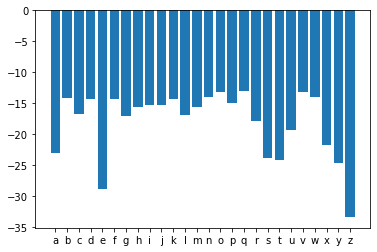

In [77]:
temperature=0.2
conditional_probability = np.asarray(predictions).astype("float64")
conditional_probability = np.log(conditional_probability) / temperature
plt.bar(dictionary,conditional_probability)
plt.show()

## 4.3 应用 softmax 函数
The softmax function transforms each element of a collection by computing the **exponential of each element** ***divided by*** the **sum of the exponentials of all** the elements. That is, if x is a one-dimensional numpy array:

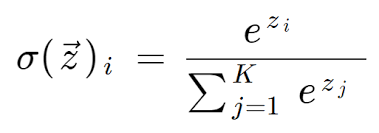

We can define our own function or use `scipy.special.softmax()` or `tf.keras.layers.Softmax()`. 

Let's define it as a function:

In [78]:
def softmax(z):
    return np.exp(z)/sum(np.exp(z))

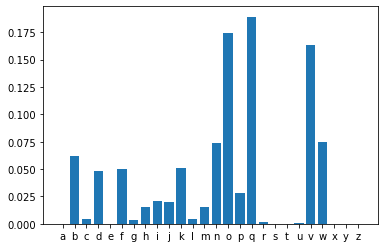

In [79]:
reweighted_conditional_probability = softmax(conditional_probability)
plt.bar(dictionary,reweighted_conditional_probability)
plt.show()

## 4.4 从 reweighted 的分布中，重新采样下一个字母

We can draw a sample using a **multinomial distribution**. 

The **parameters** of the multinomial distribution function are: 
* **n**: int, Number of experiments.

* **pvals**: sequence of floats, length p. Probabilities of each of the p different outcomes. These must sum to 1 (however, the last element is always assumed to account for the remaining probability, as long as sum(pvals[:-1]) <= 1).

* **size**: int or tuple of ints, optional. Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.

We will call the multinomial distribution function with the parameters `(1, reweighted_conditional_probability, 1)` because we want only **1 draw experiment** from **reweighted_conditional_probability** to select (sample) **1 output**. 

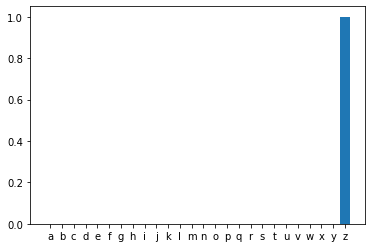

In [31]:
probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
plt.bar(dictionary,np.squeeze(probas))
plt.show()

## 4.5 把之前的操作放在一起

In [80]:
def temperature_sampling (conditional_probability, temperature=1.0):
    conditional_probability = np.asarray(conditional_probability).astype("float64")
    conditional_probability = np.log(conditional_probability) / temperature
    reweighted_conditional_probability = softmax(conditional_probability)
    probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
    plt.bar(dictionary,reweighted_conditional_probability)
    plt.show()
    return np.argmax(probas)

Note that model **predicts** the below ***conditional probability distribution*** over the vocabulary 

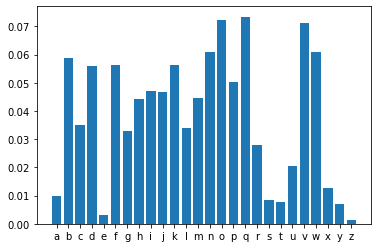

In [81]:
plt.bar(dictionary,predictions)
plt.show()

After applying **temperature sampling** with ***different temperature values***, we have the following **updated** ***conditional probability*** distributions over the vocabulary for the given **temperature values**:

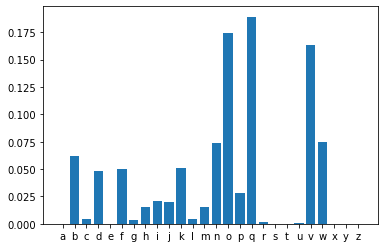

Temperature:  0.2
Sampled token:  q 



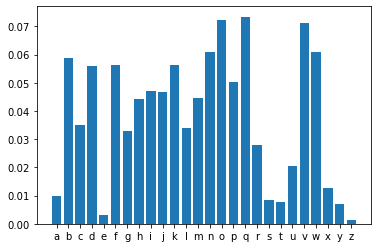

Temperature:  1.0
Sampled token:  v 



In [84]:
for temp in np.arange(0.2,1.6,0.8):
    next_token = temperature_sampling(predictions, temperature=temp)
    print("Temperature: ", temp)
    print("Sampled token: ",dictionary[next_token],"\n")

## 4.6 一些观察后的结论
[In most of the researches](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.1-text-generation-with-lstm.nb.html), it is noted that:


* If **temperature** is set to **very low values or 0**, then Temperature Sampling becomes **equivalent** to the **Greedy Search** by  always picking the next token with the highest probability.

* A **low temperature** results in extremely **repetitive** and **predictable** text, but where local structure is highly **realistic**: in particular, all words (a word being a local pattern of characters) are real words from the corpus. 

* With **higher temperatures**, the generated text becomes more **random**, **interesting**, **surprising**, even creative; it may sometimes invent completely new words (*misspelled words*) that sound somewhat **plausible**. 

* With a **high temperature**, the local structure starts breaking down and most words look like **semi-random strings** of characters. 

* Always **experiment with multiple temperature values**! A clever balance between learned structure and randomness is what makes generation interesting.



# 5. TOP-K 采样

[Fan et. al (2018)](https://arxiv.org/abs/1805.04833) introduced a simple, but very powerful sampling scheme, called Top-K sampling. 

In Top-K sampling, the **K most likely next words** are filtered and the **probability** mass is **redistributed** among only those K next words. 

**GPT2** adopted this sampling scheme, which was one of the reasons for its success in **story generation**.

To apply the Top-k sampling, we sort all the tokens accoding to the probabilites and zero-ing out the probabilities for anything below the k’th token. 




## 5.1 首先，我们有一个条件概率分布

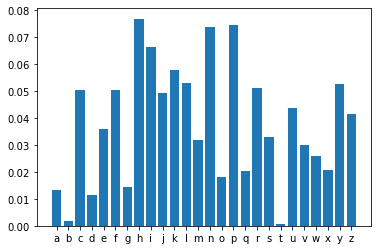

In [85]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 5.2 选择 top-k 分布

We can use `tf.math.top_k()` function to find the **k largest** entries in the vector and outputs their **values** and **indices** as vectors.

Using the **indices**, we can record the token names for plotting names of the tokens.



In [87]:
k=5
top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
top_k_indices = np.asarray(top_k_indices).astype("int32")
top_k_tokens=[dictionary[i] for i in top_k_indices]
top_k_indices, top_k_tokens

(array([ 7, 15, 13,  8, 10], dtype=int32), ['h', 'p', 'n', 'i', 'k'])

## 5.3 应用 **softmax** 函数

In [88]:
top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
print('top_k_tokens: ',top_k_tokens)
print('top_k_redistributed_probability: ',top_k_redistributed_probability)
print('Total probability: ', top_k_redistributed_probability.sum())

top_k_tokens:  ['h', 'p', 'n', 'i', 'k']
top_k_redistributed_probability:  [0.21983118 0.21332353 0.21130912 0.19023508 0.16530107]
Total probability:  1.0


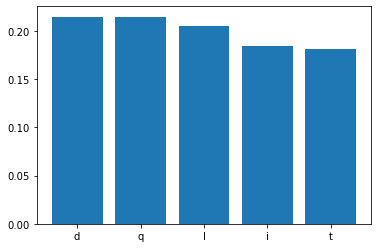

In [38]:
plt.bar(top_k_tokens,top_k_redistributed_probability)
plt.show()

## 5.4  从 reweighted 的分布中，重新采样下一个字母

In [39]:
sampled_token = np.random.choice(top_k_indices, 
                                 p=top_k_redistributed_probability)
print("Sampled token id: ",sampled_token, 
      " token: ",dictionary[sampled_token])

Sampled token id:  11  token:  l


## 5.5 把所有的步骤放在一起

In [40]:
  def top_k_sampling(conditional_probability, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
    top_k_tokens=[dictionary[i] for i in top_k_indices]
    plt.bar(top_k_tokens,top_k_redistributed_probability)
    plt.show()
    return sampled_token

Let's remember the predictions from the model once more:

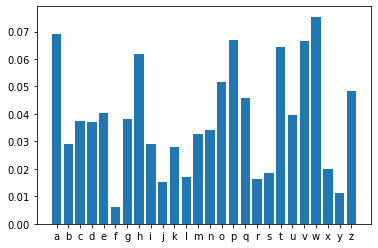

In [41]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 5.6 在使用 top-k 采样 **different k values**

We have the following updated conditional probability distributions over the vocabulary for the given k values:

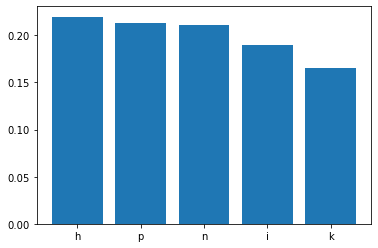

k:  5
Sampled token:  p 



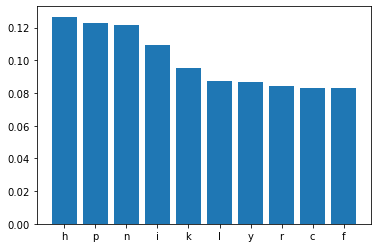

k:  10
Sampled token:  h 



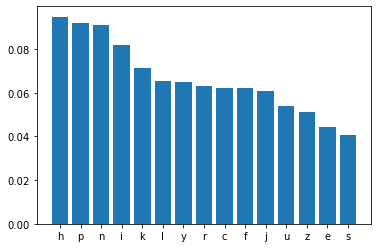

k:  15
Sampled token:  f 



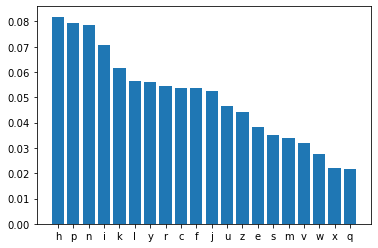

k:  20
Sampled token:  v 



In [89]:
for k in range (5, 25, 5):
  next_token = top_k_sampling(predictions, k=k)
  print("k: ", k)
  print("Sampled token: ",dictionary[next_token],"\n")

## 5.7 一些观察后的结论

In the studies, it is reported that the top-k sampling appears to **improve quality** by **removing the tail** and making it less likely to go off topic. 

However in some cases, 
* there are **many tokens** we could sample from reasonably (***broad distribution***), and 

* in some cases, there are **few tokens** (***narrow distribution***).

Therefore, **k** value should be chosen **carefully**.


# 6. Top-p 采样

There are many other methods proposed for sampling. The below ones  are the most common. I leave their implementation to you as an exercise :)

* **Top-P Sampling (Nucleus sampling)**: Another way to exclude very low probability tokens is to include the most probable tokens that make up the “nucleus” of the probability mass function (PMF), such that the **sum of the most probable tokens just reaches** ***p***. In other words, based on a parameter 0<=p<=1, Top-P Sampling aggregates the **smallest set of words that have summed probability mass p**. It can be thought of as a variation of top-k sampling with dynamic k. For details check [this blog](https://medium.com/ai2-blog/a-guide-to-language-model-sampling-in-allennlp-3b1239274bc3).


https://github.com/huggingface/transformers/blob/7959d835996d3c019b9cc9820982f7bf501fb876/src/transformers/generation_tf_utils.py#L1010


In [90]:
def scatter_values_on_batch_indices(values, batch_indices):
    shape = shape_list(batch_indices)
    # broadcast batch dim to shape
    broad_casted_batch_dims = tf.reshape(tf.broadcast_to(tf.expand_dims(tf.range(shape[0]), axis=-1), shape), [1, -1])
    # transform batch_indices to pair_indices
    pair_indices = tf.transpose(tf.concat([broad_casted_batch_dims, tf.reshape(batch_indices, [1, -1])], 0))
    # scatter values to pair indices
    return tf.scatter_nd(pair_indices, tf.reshape(values, [-1]), shape)


def set_tensor_by_indices_to_value(tensor, indices, value):
    # create value_tensor since tensor value assignment is not possible in TF
    value_tensor = tf.zeros_like(tensor) + value
    return tf.where(indices, value_tensor, tensor)


def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [57]:
def top_p_decoding(logits, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    sorted_indices = tf.argsort(logits, direction="DESCENDING")
    sorted_logits = tf.gather(
        logits, sorted_indices, axis=-1, batch_dims=1
    )  # expects logits to be of dim (batch_size, vocab_size)

    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
    sorted_indices_to_remove = cumulative_probs > top_p

    if min_tokens_to_keep > 1:
        # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
        sorted_indices_to_remove = tf.concat(
            [
                tf.zeros_like(sorted_indices_to_remove[:, :min_tokens_to_keep]),
                sorted_indices_to_remove[:, min_tokens_to_keep:],
            ],
            -1,
        )

    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove = tf.roll(sorted_indices_to_remove, 1, axis=-1)
    sorted_indices_to_remove = tf.concat(
        [tf.zeros_like(sorted_indices_to_remove[:, :1]), sorted_indices_to_remove[:, 1:]],
        -1,
    )
    # scatter sorted tensors to original indexing
    indices_to_remove = scatter_values_on_batch_indices(sorted_indices_to_remove, sorted_indices)
    logits = set_tensor_by_indices_to_value(logits, indices_to_remove, filter_value)
    return logits

In [61]:
n = 10

data = []
for i in range(10):
    prediction = model.predict()
    data.append(prediction)
data = array(data)
print(data)
result = top_p_decoding(data, 0.5)

for seq in result:
	print(seq)

[[0.00073118 0.06568149 0.0213184  0.07587179 0.08429674 0.06946692
  0.00319344 0.0384745  0.00869943 0.03062844 0.01938749 0.02816136
  0.08052579 0.00405189 0.02828189 0.04850553 0.07640293 0.08338979
  0.0266531  0.01150622 0.01584079 0.01826268 0.01835745 0.03334365
  0.07745944 0.03150767]
 [0.00523709 0.03605856 0.00167807 0.08140427 0.07973866 0.01673287
  0.04090189 0.0662777  0.01190433 0.03227306 0.07205908 0.01810662
  0.01370839 0.01108736 0.02115332 0.06292857 0.07276515 0.034331
  0.0483105  0.04447168 0.01541278 0.01166064 0.08753009 0.05513251
  0.04084369 0.01829215]
 [0.01698053 0.01490436 0.00799628 0.07538737 0.01787537 0.00903102
  0.07706548 0.07552334 0.02404578 0.01891239 0.0215558  0.01666569
  0.08809354 0.03062136 0.06292243 0.07513181 0.07014554 0.00691578
  0.02693142 0.01695099 0.07538758 0.01046979 0.07521536 0.02415884
  0.00777104 0.05334109]
 [0.0517663  0.02015316 0.03811684 0.02007641 0.03251095 0.06425428
  0.01590715 0.0397802  0.03596112 0.063731

---
## 总结


In this tutorial, we discussed the **sampling** in text generation and **codded three sampling methods**.

We also discussed the **pros and cons** of these methods.

In general, it is advised to experiment with **multiple sampling methods**. 

Moreover, it is a good idea to set the parameters of these models such that a **balance between learned structure and randomness** is created. 

In this way, we can expect to **generate an interesting text**.

If you'd like, you can implement the ***Top-P Sampling and Beam Search*** by **yourself**.

